In [1]:
import pstats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
p = pstats.Stats('time-profile-2019-03-29-00-37.txt')
p.sort_stats('cumulative').print_stats(10)

Mon Apr  1 19:01:35 2019    time-profile-2019-03-29-00-37.txt

         169694912 function calls (169690843 primitive calls) in 84336.187 seconds

   Ordered by: cumulative time
   List reduced from 1135 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     64/1    0.001    0.000 84336.187 84336.187 {built-in method builtins.exec}
        1    0.159    0.159 84336.187 84336.187 <string>:1(<module>)
        1    0.523    0.523 84336.025 84336.025 ../general-game-playing-tpg/performance-test.py:54(runTpg)
      300    0.013    0.000 83817.348  279.391 /home/the_ryan_amaral/anaconda3/lib/python3.7/multiprocessing/pool.py:263(map)
      300    0.005    0.000 83817.299  279.391 /home/the_ryan_amaral/anaconda3/lib/python3.7/multiprocessing/pool.py:650(get)
      300    0.002    0.000 83817.290  279.391 /home/the_ryan_amaral/anaconda3/lib/python3.7/multiprocessing/pool.py:647(wait)
      300    0.006    0.000 83817.288  279.391 /home/the_r

In [3]:
p = pstats.Stats('time-profile-2019-03-30-02-22.txt')
p.sort_stats('cumulative').print_stats(10)

Mon Apr  1 19:01:35 2019    time-profile-2019-03-30-02-22.txt

         152520389 function calls (152515288 primitive calls) in 234352.261 seconds

   Ordered by: cumulative time
   List reduced from 1135 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     64/1    0.001    0.000 234352.261 234352.261 {built-in method builtins.exec}
        1    0.175    0.175 234352.261 234352.261 <string>:1(<module>)
        1    0.565    0.565 234352.084 234352.084 ../general-game-playing-tpg/performance-test.py:54(runTpg)
      300    0.014    0.000 233889.388  779.631 /home/the_ryan_amaral/anaconda3/lib/python3.7/multiprocessing/pool.py:263(map)
      300    0.005    0.000 233889.340  779.631 /home/the_ryan_amaral/anaconda3/lib/python3.7/multiprocessing/pool.py:650(get)
      300    0.002    0.000 233889.329  779.631 /home/the_ryan_amaral/anaconda3/lib/python3.7/multiprocessing/pool.py:647(wait)
      300    0.004    0.000 233889.327  779.631 

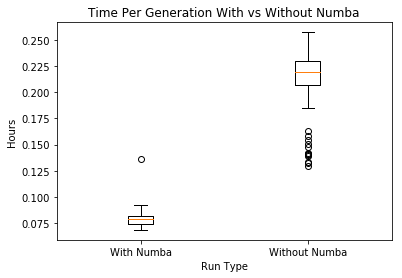

In [15]:
dfNumba = pd.read_csv('tpg-log-2019-03-29-00-37.txt')
dfNoNumba = pd.read_csv('tpg-log-2019-03-30-02-22.txt')

timesNumba = []
prevTimeNumba = 0
timesNoNumba = []
prevTimeNoNumba = 0
for rowNumba, rowNoNumba in [(dfNumba.iloc[i], dfNoNumba.iloc[i]) for i in range(len(dfNumba))]:
    timesNumba.append(rowNumba['hoursElapsed'] - prevTimeNumba)
    prevTimeNumba = rowNumba['hoursElapsed']
    
    timesNoNumba.append(rowNoNumba['hoursElapsed'] - prevTimeNoNumba)
    prevTimeNoNumba = rowNoNumba['hoursElapsed']
    
plt.boxplot([timesNumba, timesNoNumba], labels=['With Numba', 'Without Numba'])
#plt.ylim(-1,1)
plt.title('Time Per Generation With vs Without Numba')
plt.xlabel('Run Type')
plt.ylabel('Hours')
plt.show()

In [19]:
print('Total Hours with Numba: ' + str(dfNumba.iloc[-1,1]))
print('Total Hours without Numba: ' + str(dfNoNumba.iloc[-1,1]))

Total Hours with Numba: 23.42667371988297
Total Hours without Numba: 65.09780094285807


In [4]:
from IPython.display import clear_output
import gym
# import to do training
from tpg.tpg_trainer import TpgTrainer
# import to run an agent (always needed)
from tpg.tpg_agent import TpgAgent
import pickle # save times (explained later)
from timeit import default_timer as timer

In [5]:
# To transform pixel matrix to a single vector.
def getState(inState):
    # each row is all 1 color
    rgbRows = np.reshape(inState,(len(inState[0])*len(inState), 3)).T

    # add each with appropriate shifting
    # get RRRRRRRR GGGGGGGG BBBBBBBB
    return np.add(np.left_shift(rgbRows[0], 16),
        np.add(np.left_shift(rgbRows[1], 8), rgbRows[2]))

def runTestTpg():
    env = gym.make('Boxing-v0') # make the environment
    tstart = timer()
    # first create an instance of the TpgTrainer
    # this creates the whole population and everything
    trainer = TpgTrainer(actions=range(env.action_space.n), teamPopSize=50)

    curScores = [] # hold scores in a generation
    summaryScores = [] # record score summaries for each gen (min, max, avg)
    times = []

    # 3 generations (super small, just for action timing)
    for gen in range(3): # generation loop
        curScores = [] # new list per gen
        print('New Gen: ' + str(gen))
        while True: # loop to go through agents
            teamNum = trainer.remainingAgents()
            agent = trainer.getNextAgent()
            if agent is None:
                break # no more agents, so proceed to next gen

            state = env.reset() # get initial state and prep environment
            score = 0
            for i in range(18000): # run episodes that last 18000 frames

                # must transform to at-least int-32 (for my getState to bitshift correctly)
                mstate = getState(np.array(state, dtype=np.int32))

                start = timer()
                act = agent.act(mstate, vizd=False) # get action from agent
                times.append(timer()-start)

                # feedback from env
                state, reward, isDone, debug = env.step(act)
                score += reward # accumulate reward in score
                if isDone:
                    break # end early if losing state

            #print(np.unique(agent.screenIndexed, return_counts=True))
            agent.reward(score) # must reward agent (if didn't already score)
            print(str(teamNum) + ': ' + str(score))
            #print(np.unique(agent.screenIndexed, return_counts=True))
            curScores.append(score) # store score

        # at end of generation, make summary of scores
        summaryScores.append((min(curScores), max(curScores),
                        sum(curScores)/len(curScores))) # min, max, avg
        trainer.evolve()

    clear_output(wait=True)
    print('Time Taken (Seconds): ' + str(timer()- tstart))
    print('Results:\nMin, Max, Avg')
    for result in summaryScores:
        print(result[0],result[1],result[2])
        
    return times

In [30]:
# with Numba
#numbaTimes = runTestTpg()
#pickle.dump(numbaTimes, open('timesNumba.pkl', 'wb'))
""" Cell Output
Time Taken (Seconds): 281.34087297099904
Results:
Min, Max, Avg
-100.0 0.0 -44.18
-100.0 1.0 -37.32608695652174
-100.0 1.0 -27.55
"""

Time Taken (Seconds): 281.34087297099904
Results:
Min, Max, Avg
-100.0 0.0 -44.18
-100.0 1.0 -37.32608695652174
-100.0 1.0 -27.55


In [6]:
# without Numba (to run this I just manually commented out #njit on the 
# runProgram function in the TPG learner file, then restarted the kernel,
# which is why the runs are saved to files despite being quick.)
#numbalessTimes = runTestTpg()
#pickle.dump(numbalessTimes, open('timesNumbaless.pkl', 'wb'))
""" Cell Output
Time Taken (Seconds): 481.2702215889949
Results:
Min, Max, Avg
-100.0 -12.0 -50.5
-100.0 -2.0 -37.333333333333336
-100.0 -2.0 -33.225
"""

Time Taken (Seconds): 481.2702215889949
Results:
Min, Max, Avg
-100.0 -12.0 -50.5
-100.0 -2.0 -37.333333333333336
-100.0 -2.0 -33.225


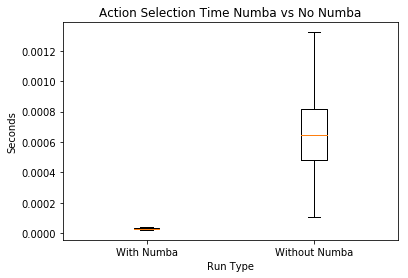

In [12]:
timesNumba = pickle.load(open('timesNumba.pkl', 'rb'))
timesNumbaless = pickle.load(open('timesNumbaless.pkl', 'rb'))

plt.boxplot([timesNumba, timesNumbaless], labels=['With Numba', 'Without Numba'],showfliers=False)
plt.title('Action Selection Time Numba vs No Numba')
plt.xlabel('Run Type')
plt.ylabel('Seconds')
plt.show()

In [18]:
print('Mean Action Selection Time with Numba: \n' + str('%f'%(sum(timesNumba)/len(timesNumba))))
print('Mean Action Selection Time without Numba: \n' + str('%f'%(sum(timesNumbaless)/len(timesNumbaless))))

Mean Action Selection Time with Numba: 
0.000031
Mean Action Selection Time without Numba: 
0.000679
